In [12]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, numpy as np, pandas as pd
sn.set_context('notebook')

# Bayesian Inference and Monte Carlo methods

This notebook introduces a Bayesian approach to model calibration and also presents the basics of how to use Monte Carlo (MC) methods to sample from difficult distributions.

[Comment applicable throughout: Luigi always preferred the word 'density' to 'distribution', so that it applies to discrete as well as continuous data]

## 1.1. A Bayesian model calibration framework

At the end of the first notebook we introduced Bayes' Theorem:

$$P(y \mid x) = \frac{P(x \mid y)P(y)}{\int_y P(x \mid y)P(y) dy}$$

and in the second notebook we discussed model auto-calibration, which led us to the concept of the likelihood function. 

In a typical calibration situation we have an environmental model that includes some poorly defined parameters, and we also have observed data for the variable we're trying to simulate, together with contemporary observations for all the input datasets we need to run the model. We often also have some idea of roughly what values the parameters should take (e.g. from ranges in the literature), but we don't know enough about them to be able to use the model without calibrating it first. 

There are lots of different ways of calibrating models, but here we're going to focus on the Bayesian approach. In this case, the aim of model calibration is to start off with whatever **prior information** we have about the parameters (e.g. literature values) and then **refine** these estimates using the observed data. If our model has $\theta =  \{\theta_1, .., \theta_n\}$ poorly constrained parameters, we can capture our **prior** beliefs by defining distributions for each of them. For example, in the simplest case we might define **uniform distributions** for each parameter with the maximum and minimum values for each distribution based upon literature ranges. The **joint distribution** over all the $\theta_i$ is the **prior distribution**, $P(\theta)$, of our parameters. The individual distributions for each parameter are known as **marginal priors**.

We want to take the prior distribution and *update* it based on the observed data. In other words, we want to calculate a new distribution for the parameters **given** the observations, $P(\theta \mid D)$, where $D$ is the observed data. This is called the **posterior distribution**, because it represents what we know about the parameters *after* we've incorporated the information from the observations. Once we have the posterior distribution, we can calculate **marginal posterior probability densities** (marginal posteriors) for each parameter, which we can compare to our marginal prior distributions to see how much we've learned from the calibration process (see notebook 1 for a quick overview of marginalisation).

We therefore want to calculate $P(\theta \mid D)$, but it's not immediately obvious how to do this. This is where Bayes' Theorem comes in. From the equation above, we can write:

$$P(\theta \mid D) = \frac{P(D \mid \theta)P(\theta)}{\int_\theta P(D \mid \theta)P(\theta) d\theta}$$

How does this help? Well, $P(\theta)$ is the prior distribution, which we already know. $P(D \mid \theta)$ is the probability of the observations, *given* a particular set of parameters. In other words, if we run the model with a particular set of parameters, what is the probabiltiy that it produces the observed data? From notebook 2, you should be able to see that this is the **likelihood function**. This gives us everything we need to work out the right-hand side of the equation above: the numerator in the fraction is the prior multiplied by the likelihood, and the denominator is the integral of the numerator over the entire parameter space. This integral is actually just a constant: it's a scaling factor which "normalises" the numerator so that the total volume under the posterior surface is equal to one. It is properly referred to as **the probability of the data** or, sometimes, as the **evidence**, but it's also often just called the **normalising constant**.

This means we can re-write Bayes' Theorem as:

$$posterior = \frac{likelihood \times prior}{normalising\;constant}$$

In principle, at least, Bayes' Theorem gives us everything we need to calculate $P(\theta \mid D)$. In practice, the integral in the denominator tends to be tricky to evaluate because it frequently has no analytical solution. Also, because it involves integrating over the *entire* parameter space, numerical approximations of the integral are often *expensive* to calculate (i.e. they take a long time to run, even on a powerful computer). Fortunately, in many applications we don't need to know the exact posterior distribution - anything *proportional* to it will do. Because the denominator in Bayes' equation is ultimately just a constant, we can write instead:

$$P(\theta \mid D) \propto P(D \mid \theta)P(\theta)$$
<br><br>
$$posterior \propto likelihood \times prior$$

Once we have the posterior distribution, we can calculate marginal distributions for each parameter by integrating. Recall from notebook 1 that for a two-dimensional joint distribution, $P(x,y)$, the marginal distribution for $x$ was obtained by "integrating out" $y$:

$$P(x) = \int_y P(x,y) dy$$

If our model has $n$ parameters, $\{\theta_1, .., \theta_n\}$, the marginal distribution for each parameter is found by "integrating out" all the others.

## 1.2. Conjugate priors

The difficulty of evaluating the posterior depends on the complexity of the prior distribution and likelihood function. If the likelihood is something simple, like a Gaussian, we can often make life easier for ourselves by choosing a **[conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior)** to ensure that the posterior will also be a friendly function. 

Choosing your prior to make the calculations easier might seem a bit arbitrary, and in fact this is one area where the Bayesian approach often comes in for criticism. However it's worth emphasising that, regardless of whether you adopt a Bayesian or a Frequentist paradigm, **["you can't do inference without making assumptions"](http://www.inference.phy.cam.ac.uk/itila/ "Quote from page 51 of David MacKay's book")**. Clearly you should only choose a conjugate prior if it also makes sense based on what you know about your parameters, but if you have a choice between two reasonable alternatives, one of which is conjugate, you might as well make things as straightforward as possible.

## 1.3. Practical difficulties

We're not going to delve into the details of conjugate priors any further because for the purposes of calibrating complex models we won't find them very useful. This is because in most cases the likelihood function will not be a simple distribution for which an obvious conjugate prior exists. More often than not, the likelihood function will be something awkward that makes the posterior density impossible to integrate analytically.

In general, when working with conceptual environmental models, we will often find ourselves in a situation where we can evaluate the posterior density for any point in the parameter space, but we ***can't write down an equation to represent it***. If this sounds odd, consider the example of the "black box" model from notebook 2. This model has just two parameters, $\alpha$ and $\beta$, and we assumed a simple, independent and identically distributed (iid) Gaussian error model to construct the likelihood function. However, it is important to realise that the likelihood function itself is **not** a simple Gaussian: the likelihood function is the combination of the deterministic ("black box") environmental model, plus the (stochastic) Gaussian error structure. We don't know what calculations are performed inside the black box, so we can't write down an algebraic equation for our likelihood function. Even if we could look at the equations inside the box, we'd probably find a set of differential equations, and we still wouldn't be able to write down a neat equation for our likelihood. What we *can* do is evaluate the posterior density for any point in the parameter space, because we can draw a set of parameters from our prior distribution and then run the model with those parameters. Once we've run the model, we can evaluate the likelihood, then we can multiply the prior probability of the parameters by the likelihood to get something that is *proportional to* the posterior density.

This distinction between what we can and can't do is very important. We're trying to map out the posterior density, and ultimately we want to integrate it to calculate marginal distributions for our model parameters. Unfortuantely, we **can't** write down the posterior density in a form that we can visualise or integrate analytically, but we **can** evaluate the posterior density at any point within the model's parameter space.

Going from being able to sample the posterior density at a discrete number of points to being able to describe it in its entirety will turn out to be pretty challenging. The first step towards achieving this is to introduce some basic **numerical methods**.

# 2. Numerical methods

This section will begin by taking a detour away from model calibration to look at the more general problem of how we can integrate functions that have no analytical solution. Once we've introduced some of the basic methods, we'll return to Bayiesin model calibration to see how they can be applied.

In one dimension, the general problem (as noted above) is that we have *something*, $P(x)$, that is proportional to a posterior density and that we can evaluate at any point $x$, but which we cannot integrate **analytically**. Our aims are to:

1. Come up with a method for estimating the shape of the distribution $P(x)$ (because even though we can evaluate it, we don't know what it looks like), and <br><br>

2. Find **numerical approximations** to integrals over $P(x)$ that are accurate enough for our purposes

3. Do so in a useful time frame, which is suited to high-dimensional parameter space.

## 2.1. Riemann sum

The [Riemann sum](https://en.wikipedia.org/wiki/Riemann_sum) is one of the simplest ways of estimating definite integrals numerically. Suppose we want to integrate a one-dimensional function, $P(x)$, between the limits $a$ and $b$. First, we divide the x-axis between these limits using $n$ equally spaced points, $x_i = \{x_1, .., x_n\}$ with a separation of $\Delta x$. The function is then evaluated at each of these points and the area beneath the curve is approximated by $n$ tall, thin rectangles, each with width $\Delta x$ and height $P(x_i)$. The area, $I$, beneath the curve can then be approximated by summing the areas of these rectangles

$$I \approx \sum_{i=1}^{n} P(x_i) \Delta x$$

As $\Delta x$ becomes small and the number of rectangles increases, this sum tends towards the value of the true integral

$$I = \int_{a}^{b} P(x) dx$$

To get a feel for how this works in practice, lets consider the following integral as an example

$$I = \int_{-4}^{4} (\sin^2 x + 0.3)e^{-0.5x^2} dx$$

This equation actually has an analytical solution, which you can either calculate by hand or by cheating with e.g. [Wolfram Alpha](http://www.wolframalpha.com/widgets/view.jsp?id=8ab70731b1553f17c11a3bbc87e0b605). Either way, the exact result is **$I = 1.836$** (to three decimal places). Let's have a go at approximating this using a Riemann sum.

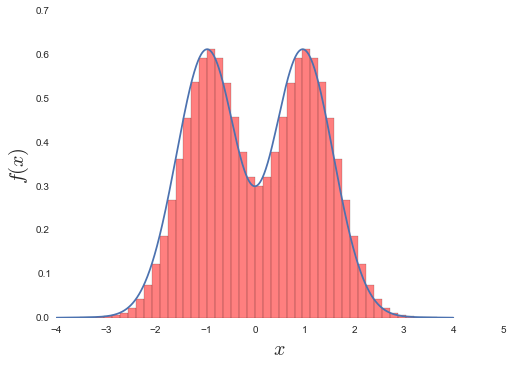

Estimated integral: 1.84 (-0.03% error)


In [13]:
def f(x):
    """ This is the function we want to integrate.
    """
    return (np.sin(x)**2 + 0.3)*np.exp(-0.5*x**2)

def riemann_sum(func, a, b, n):
    """ Approximates an integral using a Riemann sum.
    
            func is the function to be integrated
            a and b are the lower and upper integration limits respectively
            n is the number of rectangles to use in the approximation
    """
    # Values for plotting "exact" function
    x = np.linspace(a, b, 1000)
    f_x = func(x)
        
    # Calculate delta x
    Dx = (float(b) - float(a))/float(n)
    
    # Get a list of x_i
    x_i = np.arange(a, b, Dx)
    
    # Evaluate f(x) at x_i
    f_x_i = func(x_i)
    
    # Evaluate integral
    i_est = (f_x_i*Dx).sum()
    
    # Plot
    plt.plot(x, f_x)
    plt.bar(x_i, f_x_i, width=Dx, alpha=0.5, facecolor='red')
    plt.xlabel('$x$', fontsize=20)
    plt.ylabel('$f(x)$', fontsize=20)
    plt.show()
    
    return i_est

i_true = 1.836 # Analytical solution
i_est = riemann_sum(f, -4, 4, 50)
pct_error = 100*(i_est - i_true)/i_true

print 'Estimated integral: %.2f (%.2f%% error)' % (i_est, pct_error)

For a first attempt, the Riemann sum does a pretty good job of addressing the two aims listed above: 

1. The rectangles make a kind of "histogram", which gives us a pretty good feel for the shape of the function, and <br><br>

2. By summing the rectangle areas we can approximate the integral fairly accurately.

Unfortunately this approach does not generalise well for multi-dimensional problems. The one-diminsional example above uses a simple function, which we've integrated over a narrow range (between -4 and 4). In practice, our posterior densities may be much more complex, and it is not uncommon for parameter ranges in environmental models to span several orders of magnitude (i.e. the integration interval is much wider). Even if we could get away with approximating the integral using just 50 slices *per dimension*, for a model with ten dimensions the number of function evaluations required increases from 50 to $50^{10} \approx 9.8.10^{16}$. How long might this take to run? In the cell below I've streamlined the `riemann_sum` function by removing the code used for plotting. Let's use `%timeit` to see how long the code takes to execute.

In [14]:
def riemann_sum(func, a, b, n):
    """ Approximates an integral using a Riemann sum.
    
            func is the function to be integrated
            a and b are the lower and upper integration limits respectively
            n is the number of rectangles to use in the approximation
    """      
    # Calculate delta x
    Dx = (float(b) - float(a))/float(n)
    
    # Get a list of x_i
    x_i = np.arange(a, b, Dx)
    
    # Evaluate f(x) at x_i
    f_x_i = func(x_i)
    
    # Evaluate integral
    i_est = (f_x_i*Dx).sum()
    
    return i_est

%timeit riemann_sum(f, -4, 4, 50)

The slowest run took 6.32 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 32.1 µs per loop


Without worrying too much about the details of exactly what's being timed, or about the possibilities for optimisation etc., on my machine it takes about $30 \; \mu s$ to estimate the one-dimensional integral. If we scale this up to 10 dimensions we might therefore expect a runtime somewhere in the region of ***1800 years***! Hopefully this is enough to convince you that the Riemann sum approach is not very useful in practice for complex environmental models.

## 2.2. Monte Carlo (MC)

Monte Carlo (MC) is an umbrella term for a whole range of different methods, all of which involve random sampling. One big advantage of MC methods is that their accuracy is **independent of the dimensionality of the space to be sampled**, which represents a big improvement over the Riemann sum approach. MC methods are a huge subject in themselves and we're barely going to scratch the surface here.

### 2.2.1. Integration and expected values

MC methods make use of a handy link between sampling theory and integration. If we draw $n$ independent random samples, $x_i$, from a continuous random variable with distribution $P(x)$, then the [Law of Large Numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers) says that the average of the sample values converges to the **[expected value](https://en.wikipedia.org/wiki/Expected_value)** of the distribution as $n$ tends towards infinity.

For continuous random variables, the expected value, $E[x]$ can also be expressed as an integral

$$E[x] = \int_{-\infty}^{\infty} x P(x) dx$$

Furthermore, the expected value of any function, $g(x)$, given that $x$ has probability density function $P(x)$, can be written as

$$E[g(x)] = \int_{-\infty}^{\infty} g(x) P(x) dx$$

This means there is a useful link between averages of sampled values and integrals. Suppose we have some function $f(x)$ which we want to integrate

$$I = \int_{-\infty}^{\infty} f(x) dx$$

we can re-write this by multiplying the integrand by some other function $\frac{P(x)}{P(x)}$, where $P(x)$ is any probability density distribution. This is one of those funny mathematical tricks where you multiply something by one, but in a way that turns out to be useful

$$I = \int_{-\infty}^{\infty} \frac{f(x)}{P(x)} P(x) dx$$

By comparing this equation to the one above, you should be able to see that, in this form, $I$ is the expected value of $\frac{f(x)}{P(x)}$ with respect to a random variable distributed according to $P(x)$

$$I = E\left[\frac{f(x)}{P(x)}\right]$$

We can estimate $E\left[\frac{f(x)}{P(x)}\right]$ by drawing samples, $x_i$, from $P(x)$, then calculating $\frac{f(x)}{P(x)}$ and averaging the results. This means that as long as we can evaluate $f(x)$ for any $x$, and as long as we choose $P(x)$ to be something we can draw samples from easily, we can estimate the integral using a simple random sampling strategy.

### 2.2.2. Importance sampling

The first sampling strategy we will consider is called **importance sampling**. Note that although this approach provides a method for evaluating integrals (which is one of the aims listed at the start of section 2), it does not allow us to say much about the shape of the posterior distribution (which was our other main motivation for adopting numerical methods). **Rejection sampling** (see below) is a related technique that can do both.

Importance sampling is a direct extension of the discussion above concerning expected values - all we need to do is choose a probability density function, $P(x)$, that we can sample from. But what should we choose? Let's consider the same example integral that we used above to illustrate the Riemann sum

$$I = \int_{-4}^{4} (\sin^2 x + 0.3)e^{-0.5x^2} dx$$

where we already know that the true value is **$I = 1.836$**. We'll try two different sampling distributions for $P(x)$: a **uniform distribution** between -4 and 4, and a **Gaussian distribution** with mean 0 and standard deviation 1.

These three functions ($f(x)$ and the two possibilities for $P(x)$) are plotted below.

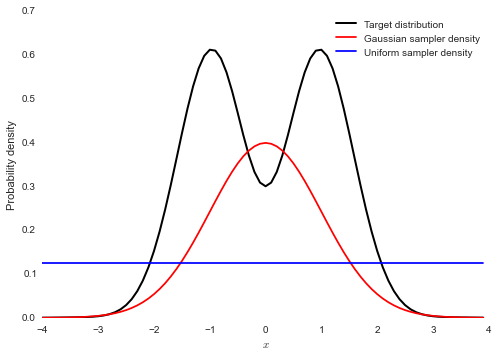

In [15]:
import scipy.stats as stats

# Range of x values for plotting
x = np.arange(-4, 4, 0.1)

# We'll try two differing "sampler densities": a uniform distribution and a Gaussian
norm = stats.norm(loc=0, scale=1)          # mu=0 and sd=1
unif = stats.uniform(loc=-4, scale=8)      # min=-4, max=4

# Get densities to plot
sampler_norm = norm.pdf(x)
sampler_unif = unif.pdf(x)
f_x = f(x) # f is defined above in Riemann sum example

# Plot
plt.plot(x, f_x, 'k-', lw=2, label='Target distribution')
plt.plot(x, sampler_norm, 'r-', label='Gaussian sampler density')
plt.plot(x, sampler_unif, 'b-', label='Uniform sampler density')
plt.xlabel('$x$')
plt.ylabel('Probability density')
plt.legend(loc='best')
plt.show()

Looking at the image above, it is clear that when we draw samples from the uniform distribution, values towards the margins of the plot will be over-represented compared to the target distribution (because $P(x) > f(x)$ in these regions), whereas towards the middle of the range values will be under-represented. To account for this we calculate weights, $\frac{f(x)}{P(x)}$, which we use to adjust the **importance** of each point in our sample.

If our sampling distribution is very different from the target distribution (as is the case for the uniform distribution above), then the algorithm will draw many points from *unimportant* regions of the parameter space, and for this reason it will take longer to achieve an accurate estimate of the integral. Based on this, we might expect the Gaussian sampler density to perform better than the uniform one, because the Gaussian assigns greater *importance* to roughly the right parts of the parameter space. Let's see if this is the case.

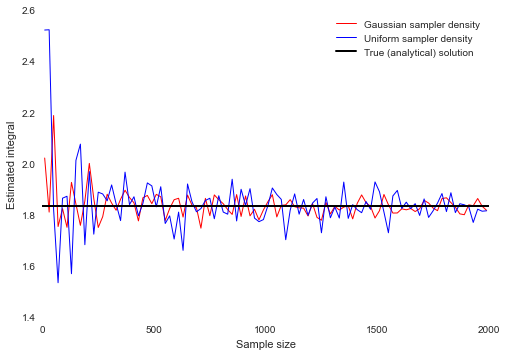

In [16]:
# Importance sampling
# Try a variety of different sample sizes
samp_sizes = range(10, 2000, 20)

# Lists to store results
unif_est = []
norm_est = []

# Loop over sample sizes
for item in samp_sizes:
    # Draw the desired number of samples, x_i, from the sampler densities
    uni_samp = unif.rvs(item)
    norm_samp = norm.rvs(item)

    # Evaluate P(x_i) and f(x_i) for uniform sampler density 
    p_i_uni = unif.pdf(uni_samp)
    f_i_uni = f(uni_samp)
    
    # Estimate expected value from uniform density by averaging
    exptd_uni = (f_i_uni/p_i_uni).mean()
    unif_est.append(exptd_uni)

    # Repeat for Gaussian sampler density
    p_i_norm = norm.pdf(norm_samp)
    f_i_norm = f(norm_samp)
    exptd_norm = (f_i_norm/p_i_norm).mean()
    norm_est.append(exptd_norm)

# Plot results based on different sample sizes and sampler densities
plt.plot(samp_sizes, norm_est, 'r-', lw=1, label='Gaussian sampler density')
plt.plot(samp_sizes, unif_est, 'b-', lw=1, label='Uniform sampler density')
plt.axhline(i_true, lw=2, color='k', label='True (analytical) solution')
plt.xlabel('Sample size')
plt.ylabel('Estimated integral')
plt.legend(loc='best')
plt.show()

First of all, it's nice to see that both sampler densities give results that are pretty close to the true value, and we can also see that as the number of samples increases the errors generally become smaller. Secondly note that, as expected, the Gaussian sampler density (red line) converges towards the true value more quickly than the uniform sampler density (blue line). Although the difference might not seem very pronounced in this one-dimensional example, the effect becomes much more exaggerated in higher dimensional spaces. This is because high-dimensional posteriors typically have a large proportion of their probability density located within a small region of the total parameter space. As the number of parameters increases, the amount of "empty space" with low probability density increases exponentially, so uniform sampling strategies spend ever-increasing fractions of their time sampling from regions with *low importance*. As a result, these strategies become highly inefficient - so much so that the only way to sample effectively is to choose a sampler density that is already very similar to your posterior density. Of course we often can't do this in practice, because we don't know what the posterior distribution looks like. This is one of the reasons why, like the Riemann sum, importance sampling is generally not very helpful for complex modelling applications.

### 2.2.3. Rejection sampling

Rejection sampling is closely related to importance sampling, but with the advantage that it allows us to draw samples from the target distribution (and therefore approximate it's shape) as well as calculating integrals. 

For illustration purposes we'll continue to work with the same example integral as above

$$I = \int_{-4}^{4} (\sin^2 x + 0.3)e^{-0.5x^2} dx$$

#### Uniform rejection sampling

To perform uniform rejection sampling, we first of all need to define a point that we know is **above** the maximum value of the function we want to integrate. We will call this value $F_{max}$. Working out $F_{max}$ can sometimes be tricky, but if necessary we could use numerical optimisation routines (like the maximum likelihood example in notebook 2) or we could make an educated guess. For the examples here, we'll assume that we know that $f(x)$ never gets above 1 (in fact, based on looking at the plot of the function shown above, we know that it only gets a little above 0.6, although of course in a real application we wouldn't know this).

As with importance sampling, we start off by choosing a **sampler distribution**, $P(x)$, which can be anything as long as we can draw from it easily. For uniform rejection sampling we choose a **uniform distribution** over the integration interval, $a$ to $b$, and draw $n$ independent samples, $x_i = \{x_1, .., x_n\}$, from it

$$x_i \sim U(a, b)$$

We also draw $n$ independent samples, $y_i = \{y_1, .., y_n\}$, from a second uniform distribution which ranges from 0 to $F_{max}$

$$y_i \sim U(0, F_{max})$$

Hopefully you can see that points with co-ordinates $(x_i, y_i)$ represent uniform random samples drawn from a rectangle with lower-left and upper-right corner co-ordinates of $(a, 0)$ and $(b, F_{max})$ respectively. For our example integral, we have

$$x_i \sim U(-4, 4) \qquad and \qquad y_i \sim U(0, 1)$$

Next, we evaluate $f(x_i)$. For each of the $x_i$, if $y_i \leq f(x_i)$, the value $x_i$ is **accepted** as a sample from $f(x)$, otherwise it is **rejected**. This is much easier to illustrate with code than it is to describe in words.

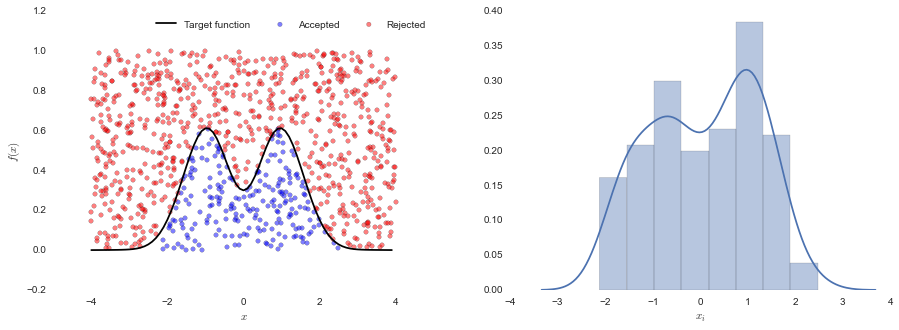

In [17]:
# Uniform rejection sampling

# Number of samples to draw
n = 1000

# Plotting "true" function for comparison
x = np.arange(-4, 4, 0.1)
f_x = f(x) # f is defined above

# Define uniform distributions
x_dist = stats.uniform(loc=-4, scale=8) # min=a, max=b
y_dist = stats.uniform(loc=0, scale=1)  # min=0, max=F_max

# Draw x_i and y_i
x_i = x_dist.rvs(n)
y_i = y_dist.rvs(n)

# Evaluate f(x_i)
f_x_i = f(x_i)

# Build into dataframe
df = pd.DataFrame({'x_i':x_i,
                   'y_i':y_i,
                   'f_x_i':f_x_i})

# Add column based on whether point is accepted or not
df['accept'] = df['y_i'] <= df['f_x_i']

# Extract accepted values to new df
accepted_df = df.loc[df['accept'] == 1]

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot (x_i, y_i), coloured according to acceptance
accepted = df[df['accept']==1].dropna()
rejected = df[df['accept']==0].dropna()
axes[0].scatter(accepted['x_i'], accepted['y_i'], c='b', label='Accepted', alpha=0.5)
axes[0].scatter(rejected['x_i'], rejected['y_i'], c='r', label='Rejected', alpha=0.5) 

# Plot "true" function for comparison
axes[0].plot(x, f_x, 'k-', label='Target function')
axes[0].legend(loc='best', ncol=3)
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$f(x)$')

# Plot normalised histogram of accepted values
sn.distplot(accepted_df['x_i'], ax=axes[1])
axes[1].set_xlabel('$x_i$')
plt.show()

The left-hand plot above gives an impression of how rejection sampling works. Because the sampling is **uniform** in the $f(x)$ ("vertical") direction, the number of "accepted" points in any vertical slice is proportional to the value of $f(x)$ over that slice. The right-hand plot shows a histogram of the accepted values, together with a smoothed version estimated via [Kernal Density Estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation). As the number of samples increases, the histogram becomes a better representation of the target function. We can therefore use this method to get an idea of the shape of $f(x)$, which was one of our main aims at the start of this section.

Furthermore, we know the points $(x_i, y_i)$ represent a uniform sample from the rectangle bounded by $(a, 0)$ and $(b, F_{max})$. This rectangle has area $A = (b - a) F_{max}$, which equals 8 units in the example considered here. The area beneath the curve (i.e. the integral) can therefore be approximated as

$$I = A \frac{n_{accept}}{n}$$

where $n$ is the total number of samples and $n_{accept}$ is the number accepted. The ratio $\frac{n_{accept}}{n}$ is called the **acceptance rate**.

In [18]:
# Estimate integral based on results above

# Calculate acceptance rate
acc_rate = float(len(accepted_df))/float(n)

# Estimate integral
i_est = 8*acc_rate
pct_error = 100*(i_est - i_true)/i_true  # i_true is defined above

print 'Acceptance rate: %.1f%%' % (acc_rate*100)
print 'Estimated integral: %.2f (%.2f%% error)' % (i_est, pct_error)

Acceptance rate: 22.7%
Estimated integral: 1.82 (-1.09% error)


#### Non-unifrom rejection sampling

The example above illustrates why the unifrom sampling strategy is inefficient: towards the margins of the target function, the algorithm is generating lots of samples that are rejected, because the target function has low density here compared to the uniform density of our sampling distribution. 

As with importance sampling, we can make the algorithm more efficient by changing our sampling strategy. Suppose we can identify a distribution, $Q(x)$, that we can sample from easily, and we can also identify a constant, $m$, such that

$$mQ(x) > f(x)$$

everywhere in the integration interval. If $mQ(x)$ is broadly similar in shape to $f(x)$, then samples drawn from it are more likely to be accepted, and the algorithm will converge more rapidly. One possible choice for $mQ(x)$ for the example given above might be

$$mQ(x) = 1.5e^{-0.5x^2}$$

This is $1.5 \sqrt{2 \pi}$ times a Gaussian distribution with mean 0 and standard devation 1 (see notebook 1 for a reminder about the form of a Gaussian distribution). In other words, if we choose

$$m = 1.5 \sqrt{2 \pi} \qquad and \qquad Q(x) \sim \mathcal{N}(0, 1)$$

then we have a function, $mQ(x)$ that is greater than $f(x)$ everywhere within the integration interval.

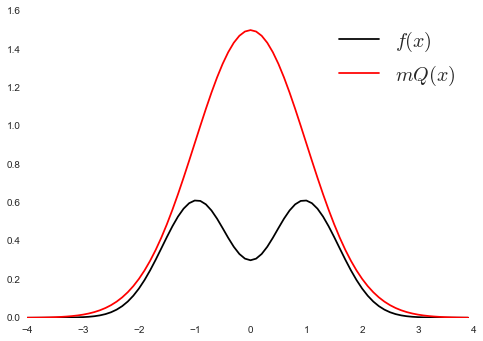

In [19]:
# Plot f(x) and Q(x)
x = np.arange(-4, 4, 0.1)
f_x = f(x) # f is defined above
mQ_x = 1.5*np.exp(-0.5*x**2)

plt.plot(x, f_x, 'k-', label='$f(x)$')
plt.plot(x, mQ_x, 'r-', label='$mQ(x)$')
plt.legend(loc='best', fontsize=20)
plt.show()

From the plot above, you can see that by drawing our samples, $x_i$, from $Q(x)$ and then multiplying by $m$, we should generate more samples from regions where $f(x)$ is large. This gives higher acceptance rates compared to the uniform sampling alternative.

To perform rejection sampling using a non-unifrom distribution, we first draw a value $x_i$ from our sampling distribution, $Q(x)$ (which for this example is a Gaussian distribution with mean 0 and standard deviation 1). We then evaluate $Q(x_i)$ and multiply by $m$.

Next, we draw a value $y_i$ **uniformly** from $U(0, mQ(x_i))$ and we accept $x_i$ as a sample from $f(x)$ if $y_i \leq f(x_i)$. It is important to note that $y_i$ is **always** drawn from a **uniform** distribution: we need to sample uniformly in the "vertical" direction so that the number of accepted samples is proportional to the density below $f(x)$. It is the sampling distribution for the $x$ direction that we can change to improve the efficiency of the algorithm.

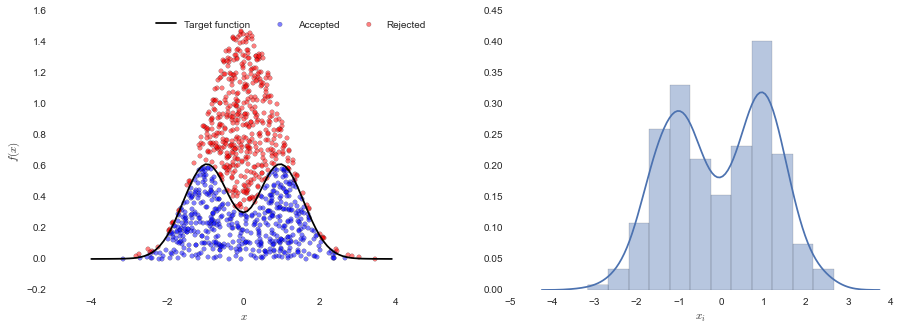

In [20]:
# Non-uniform rejection sampling

# Number of samples to draw
n = 1000

# Define Gaussian Q(x), with sampling limited to integration interval (-4 to 4)
Q_x = stats.truncnorm(-4, 4, loc=0, scale=1) # mean=0, sd=1

# Draw from Q(x)
x_i = Q_x.rvs(n)

# Evaluate mQ(x_i)
mQ_x_i = 1.5*np.exp(-0.5*x_i**2)
    
# Generate n uniform distributions between 0 and mQ_x_i
y_dist = stats.uniform(loc=0, scale=mQ_x_i)  # min=0, max=mQ_x_i

# Sample from these uniform distributions
y_i = y_dist.rvs(n)

# Evaluate f(x_i)
f_x_i = f(x_i)

# Build into dataframe
df = pd.DataFrame({'x_i':x_i,
                   'y_i':y_i,
                   'f_x_i':f_x_i})

# Add column based on whether point is accepted or not
df['accept'] = df['y_i'] <= df['f_x_i']

# Extract accepted values to new df
accepted_df = df.loc[df['accept'] == 1]

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot (x_i, y_i), coloured according to acceptance
accepted = df[df['accept']==1].dropna()
rejected = df[df['accept']==0].dropna()
axes[0].scatter(accepted['x_i'], accepted['y_i'], c='b', label='Accepted', alpha=0.5)
axes[0].scatter(rejected['x_i'], rejected['y_i'], c='r', label='Rejected', alpha=0.5) 

# Plot "true" function for comparison
axes[0].plot(x, f_x, 'k-', label='Target function')
axes[0].legend(loc='best', ncol=3)
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$f(x)$')

# Plot normalised histogram of accepted values
sn.distplot(accepted_df['x_i'], ax=axes[1])
axes[1].set_xlabel('$x_i$')
plt.show()

As before, we can estimate the integral as the acceptance rate, $\frac{n_{accept}}{n}$, multiplied by the area under the sampling function, $mQ(x)$. This area, $A$, is given by

$$A = \int_{-4}^{4} 1.5e^{-0.5x^2} dx = 3.760$$

In [21]:
# Estimate integral based on non-uniform results

# Calculate acceptance rate
acc_rate = float(len(accepted_df))/float(n)

# Estimate integral
i_est = 3.760*acc_rate
pct_error = 100*(i_est - i_true)/i_true  # i_true is defined above

print 'Acceptance rate: %.1f%%' % (acc_rate*100)
print 'Estimated integral: %.2f (%.2f%% error)' % (i_est, pct_error)

Acceptance rate: 49.9%
Estimated integral: 1.88 (2.19% error)


Note that this approach is associated with higher acceptance rates than the uniform sampling example.

Unfortunately, like the other methods discussed so far, rejection sampling is challenging to use in practice when dealing with complex models. The main issues are similar to those described above for importance sampling: as the dimensionality of the problem increases, the volume of "low density" space expands exponentially. This means that to achieve reasonable acceptance rates you need a sampling function, $mQ(x)$ that is already very similar to your target function. Rejection sampling also has the additional constraint that $mQ(x)$ must be greater than $f(x)$ over the entire region of interest. One way to achieve this is simply to make $m$ very large, but this usually prevents $mQ(x)$ from being a good match for $f(x)$, so acceptance rates go down. 

Ultimately, rejection sampling in this form will not help us much in calibrating complex models, but it does introduce some basic principles that we can extend to create techniques that **can** cope with high dimensional parameter spaces. We'll get to some of these in the next notebook, which considers some basic **Markov chain Monte Carlo (MCMC)** methods.

# 3. Summary

1. Within a Bayesian framework, what we want to find is the **posterior probability density**, $P(\theta \mid D)$, which is proportional to the **prior**, $P(\theta)$ multiplied by the **likelihood**, $P(D \mid \theta)$. <br><br>

2. Because the likelihood function is often complex, we need to rely on **numerical methods** to investigate the form of the posterior distribution.<br><br>

3. Techniques such as **importance** and **rejection** sampling can be used to estimate the shape of the posterior, as well as for calculating integrals related to it.<br><br>

4. Most straightforward sampling techniques struggle to deal with high-dimensional parameter spaces in reasonable computational time frames. Improving performance typically involves identifying functions that are almost as complicated as the posterior were trying to investigate.<br><br>

5. **Markov chain Monte Carlo (MCMC)** methods (notebook 4) are able to address some (but not all) of these difficulties.